# ReThink Media MediaCloud API

This notebook will provide a user manual and example use cases for ReThink Media's MediaCloud API functions. The functions in this notebook will provide the capabilities to:

- Search different online news to count stories relevant to a query, over different time periods
- Calculate the percentage of stories within a certain context that contain important keywords
- Create wordclouds for frequent words contained in news stories
- Create plots tracking the attention given to certain topic(s) over a period of time

As an example use case for these functions, this notebook will compare the discussions around the coming out of two transgender celebrities: Caitlin Jenner and Elliot Page.

**IMPORTANT NOTE:** Make sure you have both this file, `ReThink MediaCloud API User Guide.ipynb`, and the Python file that contains the functions used, `rethink_mediacloud_functions.py`, in the same directory when you run this notebook.

## Defining Functions

The first part of the notebook will be dedicated to defining and explaining the functions within the pipeline, with an example use case to follow.

### Authentication and utility functions

The `init_mc_api()` and `clean_api_date()` functions are utility functions that are embedded within the main ones. They initialize a MediaCloud API instance and format a string date range into the format required by the API functions, respectively.

**IMPORTANT NOTE:** The MediaCloud API requires an API key in order to access the functionalities used in this notebook. You can either pass your API key into the functions, in the `api_key` argument, or create a text file named `.env` in the home folder of your notebook, containing just the following line of text:

`MC_API_KEY="your_api_key"`

### Story count for multiple sources

The `search_sources()` function counts the number of stories that contain a query that is passed into the function. Pass a query and a dictionary of source names and MediaCloud media ID's into the function, and it will return a pandas DataFrame with each source's relevant stories, total stories, and attention to the passed query, measured by percent coverage. You can also pass a range of dates into the function to make your search more specific. If you would like to see some of the stories from each source, there is also an option to add the URLs to a sample of the relevant stories from each source.

The arguments for the function are:
- `query`: The query that you would like to find relevant stories for
- `sources`: A dict of news sources to search, formatted as {`source name`: `MediaCloud ID`}
- `source_type`: "media" or "collection" (default "media"). MediaCloud has different query tags for searching individual media sources versus searching source collections, and this parameter specifies which one you would like to use.
- `date_range`: \[`start_date`, `end_date`] for the query
- `query_context`: The overall context that you would like to search within. `query_context=None` will set the context to all of the source's stories within `date_range`, or you can pass a query to calculate attention within a more specific context.
- `api_key`: MediaCloud API key. `api_key=None` assumes that the API key is defined in a `.env` file as `MC_API_KEY`.
- `verbose`: Whether or not to print information as the function runs.
- `urls`: If `True`, the function will add a column to the DataFrame with 20 sample stories from each source relevant to the query.

### Percentage of stories that mention keywords

The `calculate_percentages()` function calculates the percentage of stories in the sources given that mention keywords and phrases of interest. The arguments for this function are:
- `keywords`: A list of keywords or phrases to search for.
- `sources`: A dict of news sources to search, formatted as {`source name`: `MediaCloud ID`}
- `source_type`: "media" or "collection" (default "media"). MediaCloud has different query tags for searching individual media sources versus searching source collections, and this parameter specifies which one you would like to use.
- `date_range`: \[`start_date`, `end_date`] for the query
- `query_context`: The overall context that you would like to search within. `query_context=None` will set the context to all of the source's stories within `date_range`, or you can pass a query to calculate attention within a more specific context.
- `api_key`: MediaCloud API key. `api_key=None` assumes that the API key is defined in a `.env` file as `MC_API_KEY`.

The function prints the percentage of stories containing each keyword, as well as the percentage of stories that mention any of the keywords, and returns an array of the percentages mentioned.

### Wordclouds

The `word_cloud()` function takes a query and produces a wordcloud, a visualization of the most popular words within stories relevant to the query. The arguments for this function are:

- `query`: The query that you would like to create a wordcloud for
- `sources`: A dict of news sources to search, formatted as {`source name`: `MediaCloud ID`}
- `date_range`: \[`start_date`, `end_date`] for the query
- `source_type`: "media" or "collection" (default "media"). MediaCloud has different query tags for searching individual media sources versus searching source collections, and this parameter specifies which one you would like to use.
- `save_img`: Boolean, whether or not to save the wordcloud image as a file
- `filename`: The filename to save the wordcloud image under. The default is "wordcloud.png"
- `custom_stopwords`: Any custom stopwords to remove from the wordcloud image. The `query` is added to the wordclouds by default
- `api_key`: MediaCloud API key. `api_key=None` assumes that the API key is defined in a `.env` file as `MC_API_KEY`
- `verbose`: Boolean, whether or not to print extra information while the function is running

### Attention over time plots:

The `attention_plots()` function tracks media attention of a given query over time. Pass queries, MediaCloud media ID's of sources, and the date range that you would like to plot into the function, and the output will be one plot, with each query's attention over time plotted against each other. You can adjust the figure size as an argument for the function as well. The arguments of this function are:

- `query`: The query that you would like to create a wordcloud for
- `sources`: A dict of news sources to search, formatted as {`source name`: `MediaCloud ID`}
- `date_range`: \[`start_date`, `end_date`] for the query
- `source_type`: "media" or "collection" (default "media"). MediaCloud has different query tags for searching individual media sources versus searching source collections, and this parameter specifies which one you would like to use.
- `query_context`: The overall context that you would like to search within. `query_context=None` will set the context to all of the source's stories within `date_range`, or you can pass a query to calculate attention within a more specific context.
- `api_key`: MediaCloud API key. `api_key=None` assumes that the API key is defined in a `.env` file as `MC_API_KEY`
- `save_img`: Boolean, whether or not to save the plot image as a file
- `filename`: The filename to save the plot image under. The default is "attention_plot.png"
- `fig_size`: A tuple of the figure size. The default is `(10,5)`
- `verbose`: Boolean, whether or not to print extra information while the function is running

## Example Use Case: Caitlin Jenner and Elliot Page

The rest of the notebook will walk through an example use case for these functions: comparing the discussions around Caitlin Jenner and Elliot Page when they came out as transgender. The example will use all of the functions defined above as a simple baseline for users to see how they work and what their outputs are.

In [1]:
# importing functions from rethink_mediacloud_functions.py (MUST BE IN THE SAME FOLDER)
from rethink_mediacloud_functions import *

# importing a module so we can time how long the functions take to run
import time

# defining queries and query labels
query1 = '"elliot page" OR "ellen page"'
query1_label = "Elliot Page"
query1_dates = ["11/21/2020", "12/07/2020"] # the weeks around Elliot Page coming out

query2 = '"caitlin jenner" OR "bruce jenner"'
query2_label = "Caitlin Jenner"
query2_dates = ["04/15/2015", "05/01/2015"] # the weeks around Caitlin Jenner coming out

# defining example sources and an example collection to search for the example use cases
example_sources = {
    "Associated Press": 1154,
    "NPR": 1096,
    "Politico": 18268,
    "Vice": 26164,
    "Buzzfeed": 6218,
    "Chicago Tribune": 9,
    "CNN Wire": 1095,
    "Fox News": 1092,
    "Houston Chronicle": 10,
    "HuffPost": 27502,
    "LA Times": 6,
    "Newsweek": 56510,
    "Reuters News": 4442,
    "Talking Points Memo": 113,
    "The Boston Globe": 15,
    "Christian Science Monitor": 3,
    "The Daily Beast": 1707,
    "The Hill": 18364,
    "The Intercept": 269138,
    "The Miami Herald": 28,
    "New York Times": 1,
    "The Wall Street Journal": 1150,
    "The Washington Post": 2,
    "The Washington Times": 101,
    "USA Today": 4,
    "Vox": 104828,
}

example_collection = {"US National Collection": 34412234}

### Story count

We can get an idea of the media attention given to these two celebrities by calculating the percentage of stories they were mentioned in around the time they came out. We can use the `search_sources()` function to accomplish this. We can set the `date_range` parameter to cover the period around each celebrity's public coming out. To expand our search, we can also add the Elliot and Caitlin's previous names to the query, in case the news outlets refer to them by either name when they came out.

In [2]:
# running and timing search_sources()
start_time = time.time()
page_counts = search_sources(query1, example_sources, date_range=query1_dates)
end_time = time.time()
print(f"Time: {round((end_time-start_time)/60, 2)} min")

# displaying the top 5 sources, sorted by attention
page_counts.sort_values(by="Attention (%)", ascending=False).head()

Query: "elliot page" OR "ellen page"
Time: 0.92 min


,Name,Relevant Stories,Total Stories,Attention (%)
MediaCloud ID,,,,
6218,Buzzfeed,5,1634,0.305998
27502,HuffPost,3,992,0.302419
56510,Newsweek,4,1727,0.231616
9,Chicago Tribune,3,1640,0.182927
1,New York Times,5,2841,0.175994


In [3]:
# running and timing search_sources()
start_time = time.time()
jenn_counts = search_sources(query2, example_sources, date_range=query2_dates)
end_time = time.time()
print(f"Time: {round((end_time-start_time)/60, 2)} min")

# displaying the top 5 sources, sorted by attention
jenn_counts.sort_values(by="Attention (%)", ascending=False).head()

Query: "caitlin jenner" OR "bruce jenner"
Time: 0.86 min


,Name,Relevant Stories,Total Stories,Attention (%)
MediaCloud ID,,,,
1707,The Daily Beast,5,342,1.461988
113,Talking Points Memo,1,90,1.111111
1095,CNN Wire,14,1651,0.847971
56510,Newsweek,3,355,0.845070
104828,Vox,2,331,0.604230


It seems like the numbers are pretty low for both queries, so let's define a more specific context to conduct our search within. We can define a `query_context` in order to restrict the search to just stories about transgender people.

We can also broaden the sources we search from by using one of MediaCloud's source collections. In this case, we'll use the United States National collection, which includes more than 250 American news sources. To use a collection, we define it the same way as a media source, in a dict, but we need to change the `source_type` argument to `"collection"`.

In [4]:
# defining query context to restrict search to transgender stories
query_context = "transgender"

In [5]:
# running and timing search_sources()
start_time = time.time()
page_counts = search_sources(query1, example_collection, source_type="collection",
                             date_range=query1_dates, query_context=query_context)
end_time = time.time()
print(f"Time: {round((end_time-start_time)/60, 2)} min")

# displaying the dataframe
page_counts

Query: "elliot page" OR "ellen page"
Time: 0.05 min


,Name,Relevant Stories,Total Stories,Attention (%)
MediaCloud ID,,,,
34412234,US National Collection,154,708,21.751412


In [6]:
# running and timing search_sources()
start_time = time.time()
jenn_counts = search_sources(query2, example_collection, source_type="collection",
                             date_range=query2_dates, query_context=query_context)
end_time = time.time()
print(f"Time: {round((end_time-start_time)/60, 2)} min")

# displaying the dataframe
jenn_counts

Query: "caitlin jenner" OR "bruce jenner"
Time: 0.05 min


,Name,Relevant Stories,Total Stories,Attention (%)
MediaCloud ID,,,,
34412234,US National Collection,325,778,41.773779


This query is more useful than the previous ones: we can see that Caitlin Jenner took up double the media attention when she came out than Elliot Page did. But this is just a number, and we can't really see how the media covered these two celebrities in terms of respect for their identities, or what they were generally associated with in news stories.

### Deadnames and misgendering

We can also check how many times the celebrities were mentioned by their previous (or "dead") names when they came out, as well as how many times they were misgendered, or referenced by the incorrect pronouns. We can use the `calculate_percentages()` function to accomplish this.

In [7]:
# checking how many times Elliot Page was referenced by his previous name
keywords = ["ellen", "she", "her", "hers"]

percentages = calculate_percentages(keywords, example_collection, source_type="collection",
                                    date_range=query1_dates, query_context=query1)

Percentage of stories within specified context that mention:

ellen: 47.49%

she: 25.7%

her: 31.84%

hers: 1.68%

All Keywords: 65.36%


In [8]:
# checking how many times Caitlin Jenner was referenced by her previous name
keywords = ["bruce", "he", "him", "his"]

percentages = calculate_percentages(keywords, example_collection, source_type="collection",
                                    date_range=query2_dates, query_context=query2)

Percentage of stories within specified context that mention:

bruce: 100.0%

he: 71.07%

him: 51.12%

his: 76.26%

All Keywords: 100.0%


We can see that Caitlin Jenner was referenced by her previous name in every news story about her when she came out, but Elliot Page was referenced by his previous name in less than half of the stories. Given the five year gap between the two celebrities coming out, this could signal that a shift had taken place in how the media talks about transgender people after they have come out.

### Wordclouds

We can get a better idea about how these celebrities are covered by looking at the word clouds generated from stories that mention them when they came out. We can use the `word_cloud()` function for this.

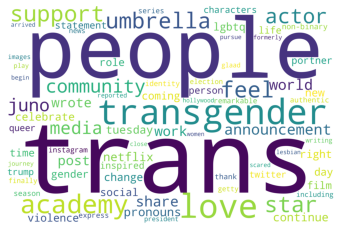

Time to run: 0.22 min


In [9]:
# building wordcloud for Elliot Page
start_time = time.time()
page_cloud = word_cloud(query1, example_collection, source_type="collection", date_range=query1_dates)
end_time = time.time()

print(f"Time to run: {round((end_time - start_time)/60, 2)} min")

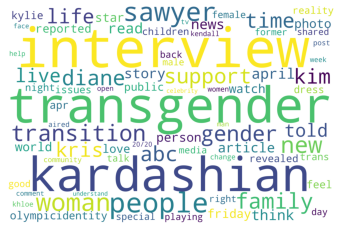

Time to run: 0.38 min


In [10]:
# building wordcloud for Caitlin Jenner
start_time = time.time()
page_cloud = word_cloud(query2, example_collection, source_type="collection", date_range=query2_dates)
end_time = time.time()

print(f"Time to run: {round((end_time - start_time)/60, 2)} min")

As expected, many of the stories mention the word "transgender" or "trans," since most of them are about Elliot and Caitlin coming out of the closet. Elliot Page's word cloud contains many of his previous roles, like Juno or Umbrella Academy, but there are also many positively-coded words, like "love," "support," and "community." Caitlin Jenner's word cloud, on the other hand, is mostly centered around her association with the Kardashians, as well as her interview with Diane Sawyer that she used to publicly come out.

### Attention over time
We can track the media attention on Elliot and Caitlin over the past year, to see how much they've been in the public eye since coming out.

Query 0: "elliot page" OR "ellen page"
Query 1: "caitlin jenner" OR "bruce jenner"


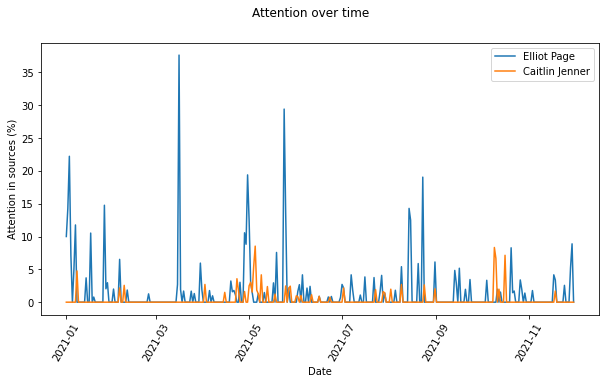

Time to run: 0.14 min


In [11]:
# adding both queries to a list for the function to parse
queries = [query1, query2]
query_labels = [query1_label, query2_label]

# defining date range
date_range = ["1/1/2021", "11/30/2021"]

# running and timing function
start_time = time.time()
attention_plot = attention_plots(queries, example_collection, source_type="collection", date_range=date_range,
                                 query_labels=query_labels, query_context=query_context, verbose=True)
end_time = time.time()
print(f"Time to run: {round((end_time-start_time)/60, 2)} min")

From the plot, we can see that Elliot Page was a larger part of the transgender coverage throughout the past year than Caitlin Jenner, and had several spikes in media coverage throughout the year.